In [1]:
import csv
import pandas as pd

In [2]:
#para todos retornos de execução de códigos sejam apresentados
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Definição das colunas de acordo com o leiaute fornecido pela B3

# nomes das colunas
nm_colunas = [
    'TIPREG',
    'DTPREG',
    'CODBDI',
    'CODNEG',
    'TPMERC',
    'NOMRES',
    'ESPECI',
    'PRAZOT',
    'MODREF',
    'PREABE',
    'PREMAX',
    'PREMIN',
    'PREMED',
    'PREULT',
    'PREOFC',
    'PREOFV',
    'TOTNEG',
    'QUATOT',
    'VOLTOT',
    'PREEXE',
    'INDOPC',
    'DATVEN',
    'FATCOT',
    'PTOEXE',
    'CODISI',
    'DISMES'    
]

#tamanho das colunas
tam_colunas = [
    2,8,2,12,3,12,10,3,4,11,11,11,11,11,11,11,5,18,16,11,1,8,7,7,12,3    
]

len(tam_colunas)
len(nm_colunas)


# Carregando os arquivos da B3

import glob as gl

#df = pd.read_fwf('../../data/demo.txt',widths=tam_colunas, names=nm_colunas, skiprows=1, skipfooter=1)
#df = pd.read_fwf('..\\..\\data\\2020.txt',widths=tam_colunas, names=nm_colunas, skiprows=1, skipfooter=1)
#df = pd.read_fwf('..\\..\\data\\2020.txt',widths=tam_colunas, names=nm_colunas, skiprows=1, skipfooter=1)

lista_arq = gl.glob('..\\..\\data\\20*.txt')
lista_arq

df = pd.concat([pd.read_fwf(f,widths=tam_colunas, names=nm_colunas, skiprows=1, skipfooter=1) for f in lista_arq])

# Carregando os indicadores econômicos

In [3]:
df_ind = pd.read_excel('..\\..\\data\\dados_economicos_ipeadata.xlsx')


# Preenche com as datas que faltam e repete os dados da ultima data

In [4]:
df_ind['dtIndex']=pd.to_datetime(df_ind['Data'].apply(str).str.ljust(7,'0'), yearfirst=1)
df_ind = df_ind.set_index('dtIndex').resample('1D').mean().ffill()
df_ind[5:10]


,Data,ibovespa,dolar_venda_media,dolar_venda_final,cdi,ipca,igpm,ipca_15,pib_milhoes
dtIndex,,,,,,,,,
2014-06-06,2014.06,3.76,2.23547,2.2025,0.82,0.4,-0.74,0.47,458516.5
2014-06-07,2014.06,3.76,2.23547,2.2025,0.82,0.4,-0.74,0.47,458516.5
2014-06-08,2014.06,3.76,2.23547,2.2025,0.82,0.4,-0.74,0.47,458516.5
2014-06-09,2014.06,3.76,2.23547,2.2025,0.82,0.4,-0.74,0.47,458516.5
2014-06-10,2014.06,3.76,2.23547,2.2025,0.82,0.4,-0.74,0.47,458516.5


# identificando outros possiveis ativos para análise

#escolhendo outros ativos para estudo

am=df.query("NOMRES.str.contains('BRADESCO')")
am['CODNEG'].unique()
am=am.groupby(['CODNEG','ESPECI'])
am.CODNEG.nunique()



# Verificando a existência de valores "NaN" que possam prejudicar a análise

#df[df.isna().any(axis=1)] -> para selecionar as linhas contendo valores NaN  
df.isna().any() 

#somente PRAZOTOT possui NaN, não havendo necessidade de nenhum tipo de tratamento. Essa variável somente faz sentido para 
#mercado a termo, cujas observações não serão utilizadas neste modelo

# Filtros de ativos

# o campo CODBDI indica o código dos papéis na emissão do boletim diário de informações
# apesar de iteressar somente o CODBDI=2 ou 96 (LOTE PADRAO OU FRACIONARIO), uma análise de frequência nos indica que o arquivo possui também grande volume
# de negociação de "opções"

df['CODBDI'].unique()

df.groupby('CODBDI').count()




# filtros
# Critério 1 - somente papéis negociados em R$

df = df.query("MODREF=='R$'")

# Critério 2 - somente ACÕES ORDINÁRIAS e PREFERENCIAIS
# este critério possui dois objetivos:
# - selecionar somente os tipos de ativos mais negociados pelo investidor comum
# - reduzir o número de registros a ser trabalhado
df1 = df[df.ESPECI.str.contains('ON')]
df2 = df[df.ESPECI.str.contains('PN')]

df = pd.concat( [df1,df2])

# Critério 3 - somente LOTE PADRÃO e FRACIONÁRIO
# para este modelo, não temos interesse em outros tipos de ativo, como por exemplo recuperação judicial, opções ou leilões.
df = df.query("CODBDI in (2,96)")

# com os filtros acima aplicados, sobraram somente observações TPMERC(TIPO DE MERCADO) = 10 e 20. Ou seja, "Mercado a Vista" e "Fracionário"
df['TPMERC'].unique()
df['ESPECI'].unique()
df.count()


# Escolhendo os ativos específicos para estudo
# O treinamento do modelo será feito com os dados a PETROBRAS


In [25]:
#PETROBRAS
#df_pet = df.query("CODNEG=='PETR4'")
#df_pet = df_pet.sort_values(['DTPREG','CODNEG'])
#df_pet = df_pet.reset_index()
#df_pet['ANOPREG']=df_pet['DTPREG'].apply(str).str[:4]
#df_pet.groupby('ANOPREG').count()
#df_pet
#df_pet.to_csv('..\\..\\data\\PETR4.csv')
df_pet=pd.read_csv('..\\..\\data\\PETR4.csv')
df_pet

#VIVO
#df_viv = df.query("CODNEG=='VIVT4'")
#df_viv = df_viv.sort_values(['DTPREG','CODNEG'])
#df_viv = df_viv.reset_index()
#df_viv['ANOPREG']=df_viv['DTPREG'].apply(str).str[:4]
#df_viv.groupby('ANOPREG').count()
#df_viv
#df_viv.to_csv('..\\..\\data\\VIVT4.csv')
df_viv=pd.read_csv('..\\..\\data\\VIVT4.csv')
df_viv

#BRADESCO
 
#df_bra = df.query("CODNEG=='BBDC4'")
#df_bra = df_bra.sort_values(['DTPREG','CODNEG'])
#df_bra = df_bra.reset_index()
#df_bra['ANOPREG']=df_amz['DTPREG'].apply(str).str[:4]
#df_amz.groupby('ANOPREG').count()
#df_bra
#df_bra.to_csv('..\\..\\data\\BBDC4.csv')
df_bra=pd.read_csv('..\\..\\data\\BBDC4.csv')



,Unnamed: 0,index,TIPREG,DTPREG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,...,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES,ANOPREG
0,0,905,1,20150102,2,PETR4,10,PETROBRAS,PN,NaN,...,940397380000,4883720000,467547,9,25000000,0,9999,123100000010,0,2015
1,1,2406,1,20150105,2,PETR4,10,PETROBRAS,PN,NaN,...,861909810000,7707730000,674783,8,84000000,0,9999,123100000010,0,2015
2,2,3976,1,20150106,2,PETR4,10,PETROBRAS,PN,NaN,...,833772830000,8402340000,706839,8,84000000,0,9999,123100000010,0,2015
3,3,5700,1,20150107,2,PETR4,10,PETROBRAS,PN,NaN,...,868853080000,8553100000,733268,9,24000000,0,9999,123100000010,0,2015
4,4,7292,1,20150108,2,PETR4,10,PETROBRAS,PN,NaN,...,918866960000,8273570000,754338,6,35000000,0,9999,123100000010,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,1725,996357,1,20211223,2,PETR4,10,PETROBRAS,PN N2,NaN,...,2833433810000,2871360000,812335,5,62000000,0,9999,123100000010,0,2021
1726,1726,996358,1,20211227,2,PETR4,10,PETROBRAS,PN N2,NaN,...,2876460600000,4422790000,1265090,3,1000000,0,9999,123100000010,0,2021
1727,1727,996359,1,20211228,2,PETR4,10,PETROBRAS,PN N2,NaN,...,2878431420000,3068810000,886001,6,99000000,0,9999,123100000010,0,2021
1728,1728,996360,1,20211229,2,PETR4,10,PETROBRAS,PN N2,NaN,...,2854610880000,3550840000,1015407,3,91000000,0,9999,123100000010,0,2021


,Unnamed: 0,index,TIPREG,DTPREG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,...,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES,ANOPREG
0,0,1377,1,20150102,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4626051370000,93480000,43307,9,65000000,0,9999,123100000010,0,2015
1,1,2929,1,20150105,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4608061610000,99700000,45614,8,12000000,0,9999,123100000010,0,2015
2,2,4565,1,20150106,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4567042990000,82240000,37485,7,27000000,0,9999,123100000010,0,2015
3,3,6254,1,20150107,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4675036170000,52490000,24415,2,26000000,0,9999,123100000010,0,2015
4,4,7866,1,20150108,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4700019270000,36010000,16878,5,85000000,0,9999,123100000010,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,1452,256080,1,20201116,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,4561142150000,259410000,118073,6,22000000,0,9999,123100000010,0,2020
1453,1453,256081,1,20201117,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,4673161030000,260340000,120508,2,77000000,0,9999,123100000010,0,2020
1454,1454,256082,1,20201118,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,4670114910000,218500000,102566,0,49000000,0,9999,123100000010,0,2020
1455,1455,265642,1,20201119,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,4640107440000,175440000,82049,5,51000000,0,9999,123100000010,0,2020


In [26]:
df_bra['DTPREG']=pd.to_datetime(df_bra['DTPREG'].apply(str))
df_viv['DTPREG']=pd.to_datetime(df_bra['DTPREG'].apply(str))
df_pet['DTPREG']=pd.to_datetime(df_bra['DTPREG'].apply(str))

# cria um índice pelo campo de datas

In [27]:
df_bra['dtIndex']=df_bra['DTPREG']
df_bra = df_bra.set_index('dtIndex')

df_viv['dtIndex']=df_viv['DTPREG']
df_viv = df_viv.set_index('dtIndex')

df_pet['dtIndex']=df_pet['DTPREG']
df_pet = df_pet.set_index('dtIndex')

df_bra
df_viv
df_pet

,Unnamed: 0,index,TIPREG,DTPREG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,...,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES,ANOPREG
dtIndex,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0,131,1,2015-01-02,2,BBDC4,10,BRADESCO,PN EJ N1,NaN,...,3432172360000,780190000,270353,2,96000000,0,9999,123100000010,0,2015.0
2015-01-05,1,1539,1,2015-01-05,2,BBDC4,10,BRADESCO,PN EJ N1,NaN,...,3435238440000,773160000,263966,6,90000000,0,9999,123100000010,0,2015.0
2015-01-06,2,3080,1,2015-01-06,2,BBDC4,10,BRADESCO,PN EJ N1,NaN,...,3548179660000,996260000,347310,8,46000000,0,9999,123100000010,0,2015.0
2015-01-07,3,4745,1,2015-01-07,2,BBDC4,10,BRADESCO,PN EJ N1,NaN,...,3689298610000,1061700000,390734,7,22000000,0,9999,123100000010,0,2015.0
2015-01-08,4,6411,1,2015-01-08,2,BBDC4,10,BRADESCO,PN EJ N1,NaN,...,3708167340000,582960000,215516,0,23000000,0,9999,123100000010,0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,1725,1040486,1,2021-12-23,2,BBDC4,10,BRADESCO,PN EDJ N1,NaN,...,1926381640000,2724290000,525456,6,92000000,0,9999,123100000010,0,NaN
2021-12-27,1726,1040487,1,2021-12-27,2,BBDC4,10,BRADESCO,PN EDJ N1,NaN,...,1947330890000,2018910000,391833,1,6000000,0,9999,123100000010,0,NaN
2021-12-28,1727,1043545,1,2021-12-28,2,BBDC4,10,BRADESCO,PN EDJ N1,NaN,...,1940292880000,1751620000,340340,6,0,0,9999,123100000010,0,NaN


,Unnamed: 0,index,TIPREG,DTPREG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,...,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES,ANOPREG
dtIndex,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0,1377,1,2015-01-02,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4626051370000,93480000,43307,9,65000000,0,9999,123100000010,0,2015
2015-01-05,1,2929,1,2015-01-05,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4608061610000,99700000,45614,8,12000000,0,9999,123100000010,0,2015
2015-01-06,2,4565,1,2015-01-06,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4567042990000,82240000,37485,7,27000000,0,9999,123100000010,0,2015
2015-01-07,3,6254,1,2015-01-07,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4675036170000,52490000,24415,2,26000000,0,9999,123100000010,0,2015
2015-01-08,4,7866,1,2015-01-08,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,4700019270000,36010000,16878,5,85000000,0,9999,123100000010,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16,1452,256080,1,2020-11-16,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,4561142150000,259410000,118073,6,22000000,0,9999,123100000010,0,2020
2020-11-17,1453,256081,1,2020-11-17,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,4673161030000,260340000,120508,2,77000000,0,9999,123100000010,0,2020
2020-11-18,1454,256082,1,2020-11-18,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,4670114910000,218500000,102566,0,49000000,0,9999,123100000010,0,2020


,Unnamed: 0,index,TIPREG,DTPREG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,...,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES,ANOPREG
dtIndex,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0,905,1,2015-01-02,2,PETR4,10,PETROBRAS,PN,NaN,...,940397380000,4883720000,467547,9,25000000,0,9999,123100000010,0,2015
2015-01-05,1,2406,1,2015-01-05,2,PETR4,10,PETROBRAS,PN,NaN,...,861909810000,7707730000,674783,8,84000000,0,9999,123100000010,0,2015
2015-01-06,2,3976,1,2015-01-06,2,PETR4,10,PETROBRAS,PN,NaN,...,833772830000,8402340000,706839,8,84000000,0,9999,123100000010,0,2015
2015-01-07,3,5700,1,2015-01-07,2,PETR4,10,PETROBRAS,PN,NaN,...,868853080000,8553100000,733268,9,24000000,0,9999,123100000010,0,2015
2015-01-08,4,7292,1,2015-01-08,2,PETR4,10,PETROBRAS,PN,NaN,...,918866960000,8273570000,754338,6,35000000,0,9999,123100000010,0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,1725,996357,1,2021-12-23,2,PETR4,10,PETROBRAS,PN N2,NaN,...,2833433810000,2871360000,812335,5,62000000,0,9999,123100000010,0,2021
2021-12-27,1726,996358,1,2021-12-27,2,PETR4,10,PETROBRAS,PN N2,NaN,...,2876460600000,4422790000,1265090,3,1000000,0,9999,123100000010,0,2021
2021-12-28,1727,996359,1,2021-12-28,2,PETR4,10,PETROBRAS,PN N2,NaN,...,2878431420000,3068810000,886001,6,99000000,0,9999,123100000010,0,2021


# Join das tabelas de ativos com a tabela de índices, pela data

In [28]:

df_pet = df_pet.join(df_ind,lsuffix='atv',rsuffix='ind')
df_bra = df_bra.join(df_ind,lsuffix='atv',rsuffix='ind')
df_viv = df_viv.join(df_ind,lsuffix='atv',rsuffix='ind')

#refaz os indices
df_pet = df_pet.reset_index(drop='true')
df_bra = df_bra.reset_index(drop='true')
df_viv = df_viv.reset_index(drop='true')



# A variável PREULT , indica o último valor do ativo no dia e será a variável de trabalho

In [29]:

df_pet['PREULT']=df_pet['PREULT']/100000
valores = df_pet['PREULT']
valores.shape

(1730,)

# Vizualizando os dados

<Figure size 1800x900 with 0 Axes>

([<matplotlib.axis.XTick at 0x270a87f2df0>,
 [Text(0, 0, '2015-01-02 00:00:00'),
  Text(200, 0, '2015-10-22 00:00:00'),
  Text(400, 0, '2016-08-15 00:00:00'),
  Text(600, 0, '2017-06-06 00:00:00'),
  Text(800, 0, '2018-03-29 00:00:00'),
  Text(1000, 0, '2019-01-22 00:00:00'),
  Text(1200, 0, '2019-11-07 00:00:00'),
  Text(1400, 0, '2020-08-31 00:00:00'),
  Text(1600, 0, '2021-06-24 00:00:00')])

Text(0.5, 0, 'Datas')

Text(0, 0.5, 'Preço Final')

Text(0.5, 1.0, 'Histórico de Preço')

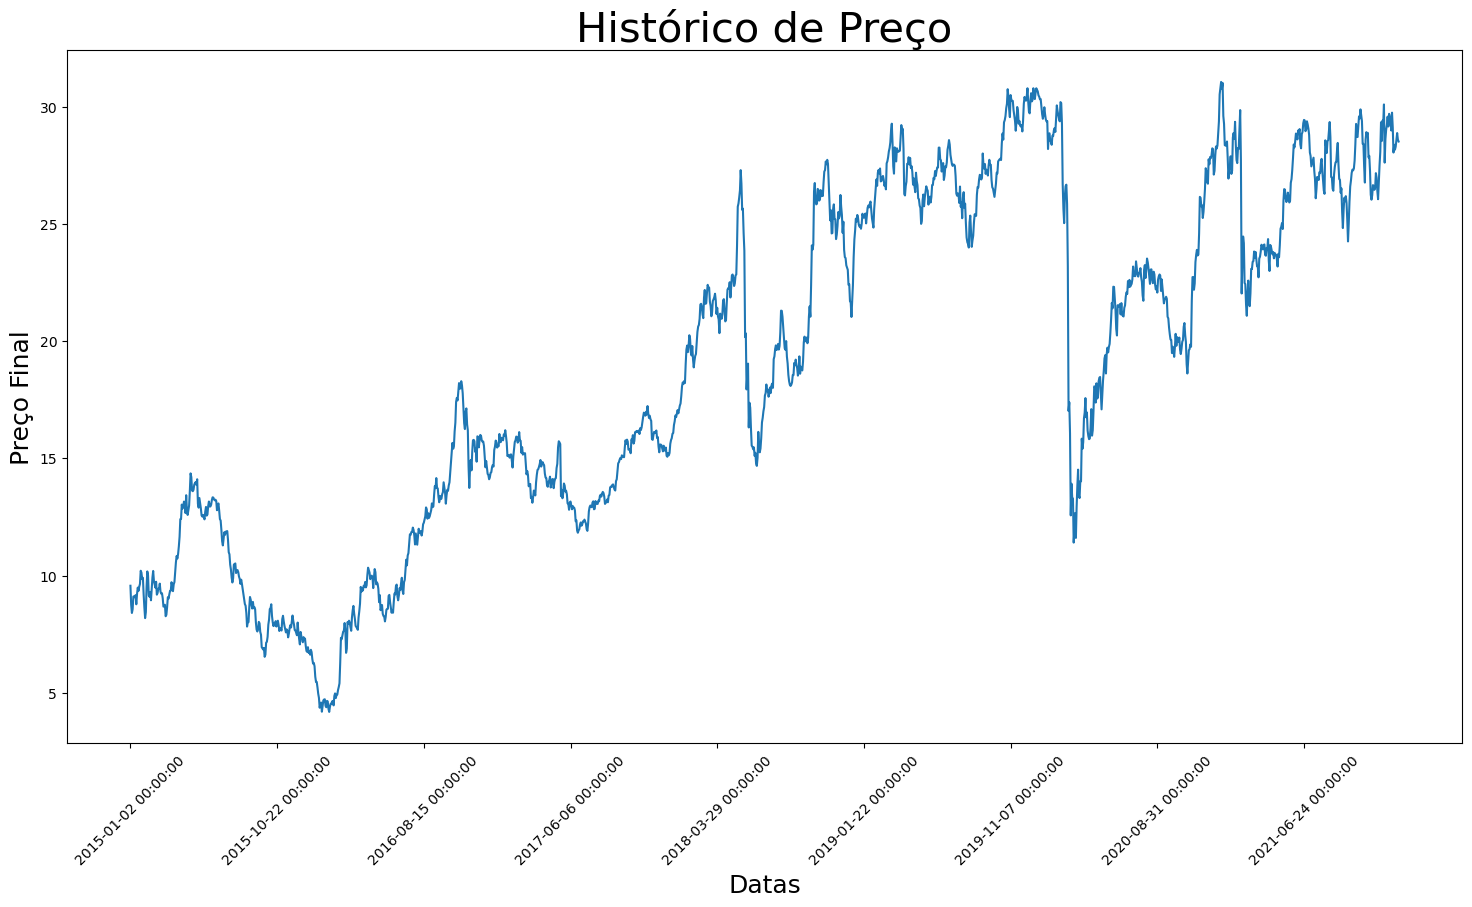

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18,9))
plt.plot(df_pet['PREULT'])
plt.xticks(range(0,df_pet.shape[0],200), df_pet['DTPREG'].loc[::200], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Final', fontsize=18)
plt.title("Histórico de Preço", fontsize=30)
plt.show()

# A variável dias_input indica o número de dias que será utilizado como informação de entrada para a predição.

## Dessa forma, para que o modelo possa predizer o valor do ativo em uma determinada data, irá utilizar como "input" os valores do ativo correspondentes aos "dias_input" anteriores.

In [32]:
#número de dias utilizados para predição (input)
dias_input = 15

# Separação entre teste e treino

In [33]:
import numpy as np

tam_treino = int(len(valores) * 0.95)
tam_teste = len(valores) - tam_treino
tam_treino
tam_teste

dados_treino, dados_teste = np.array(valores[0:tam_treino]), np.array(valores[tam_treino - dias_input:])
dados_valid = np.array(valores[tam_treino:])

dados_treino.shape,  dados_valid.shape, dados_teste.shape
dados_teste
dados_teste.shape



1643

87

((1643,), (87,), (102,))

array([26.28, 28.56, 28.31, 28.02, 28.52, 28.57, 28.94, 29.34, 28.7 ,
       27.  , 26.98, 26.5 , 26.41, 27.11, 27.43, 27.62, 27.64, 28.13,
       28.45, 27.53, 26.91, 26.88, 26.33, 26.51, 25.51, 24.82, 25.59,
       26.11, 25.96, 26.18, 25.89, 25.16, 24.25, 25.01, 25.93, 26.59,
       26.84, 27.17, 27.31, 27.28, 27.36, 27.69, 28.38, 29.26, 28.73,
       28.7 , 29.13, 29.58, 29.49, 29.88, 29.63, 29.38, 28.41, 28.41,
       27.45, 26.76, 28.6 , 28.91, 28.8 , 28.88, 27.83, 27.9 , 27.26,
       26.24, 26.03, 26.22, 26.65, 26.62, 26.45, 26.54, 27.16, 26.97,
       26.4 , 26.05, 26.76, 27.5 , 28.07, 29.33, 28.53, 29.4 , 29.29,
       30.09, 27.61, 28.61, 29.01, 29.22, 29.57, 29.15, 29.69, 29.58,
       29.36, 28.98, 29.74, 29.11, 28.04, 28.37, 28.16, 28.29, 28.6 ,
       28.87, 28.59, 28.51])

(102,)

# "plotando" o gráfico com séries de treino e input

<Figure size 1800x900 with 0 Axes>

([<matplotlib.axis.XTick at 0x270a88a3f10>,
 [Text(0, 0, '2015-01-02 00:00:00'),
  Text(90, 0, '2015-05-15 00:00:00'),
  Text(180, 0, '2015-09-23 00:00:00'),
  Text(270, 0, '2016-02-10 00:00:00'),
  Text(360, 0, '2016-06-20 00:00:00'),
  Text(450, 0, '2016-10-26 00:00:00'),
  Text(540, 0, '2017-03-09 00:00:00'),
  Text(630, 0, '2017-07-19 00:00:00'),
  Text(720, 0, '2017-11-29 00:00:00'),
  Text(810, 0, '2018-04-13 00:00:00'),
  Text(900, 0, '2018-08-22 00:00:00'),
  Text(990, 0, '2019-01-08 00:00:00'),
  Text(1080, 0, '2019-05-21 00:00:00'),
  Text(1170, 0, '2019-09-26 00:00:00'),
  Text(1260, 0, '2020-02-07 00:00:00'),
  Text(1350, 0, '2020-06-22 00:00:00'),
  Text(1440, 0, '2020-10-28 00:00:00'),
  Text(1530, 0, '2021-03-15 00:00:00'),
  Text(1620, 0, '2021-07-23 00:00:00'),
  Text(1710, 0, '2021-12-02 00:00:00')])

Text(0.5, 0, 'Datas')

Text(0, 0.5, 'Preço Final')

Text(0.5, 1.0, 'Histórico de Preço')

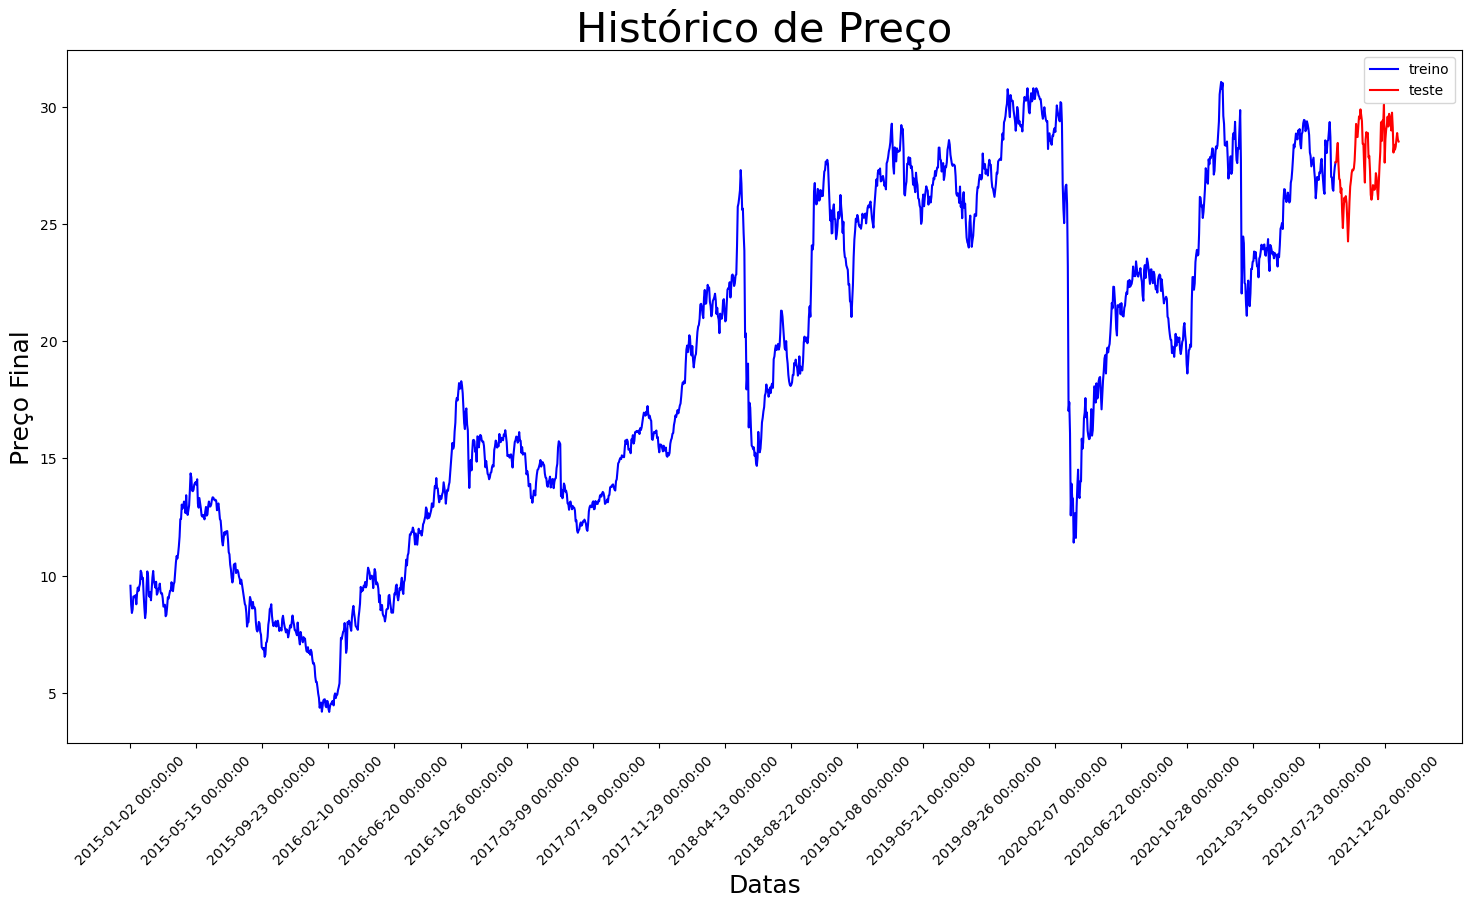

In [35]:
import matplotlib.pyplot as plt

intervalo = 90


plt.figure(figsize = (18,9))
plt.plot(df_pet['PREULT'].loc[0:tam_treino], color = 'blue', label = 'treino')
plt.plot(df_pet['PREULT'].loc[tam_treino:], color = 'red', label = 'teste')
plt.xticks(range(0,len(df_pet),intervalo), df_pet['DTPREG'].loc[::intervalo], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Final', fontsize=18)
plt.title("Histórico de Preço", fontsize=30)
plt.legend()
plt.show()




# Normalização dos dados


In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
dados_treino_z = scaler.fit_transform(np.array(dados_treino).reshape(-1,1))
dados_teste_z = scaler.transform(np.array(dados_teste).reshape(-1,1))
dados_valid_z = scaler.transform(np.array(dados_valid).reshape(-1,1))

dados_treino_z.shape
dados_teste_z.shape
dados_valid_z.shape

dados_teste_z.shape
dados_teste_z


(1643, 1)

(102, 1)

(87, 1)

(102, 1)

array([[0.82241251],
       [0.9072971 ],
       [0.89798958],
       [0.88719285],
       [0.90580789],
       [0.9076694 ],
       [0.92144453],
       [0.93633656],
       [0.91250931],
       [0.84921817],
       [0.84847357],
       [0.83060313],
       [0.82725242],
       [0.85331348],
       [0.8652271 ],
       [0.87230082],
       [0.87304542],
       [0.89128816],
       [0.90320179],
       [0.86895011],
       [0.84586746],
       [0.84475056],
       [0.82427401],
       [0.83097543],
       [0.79374535],
       [0.76805659],
       [0.79672375],
       [0.8160834 ],
       [0.81049888],
       [0.8186895 ],
       [0.80789278],
       [0.78071482],
       [0.74683544],
       [0.77513031],
       [0.80938198],
       [0.83395383],
       [0.84326136],
       [0.85554728],
       [0.86075949],
       [0.85964259],
       [0.862621  ],
       [0.87490692],
       [0.90059568],
       [0.93335815],
       [0.91362621],
       [0.91250931],
       [0.92851824],
       [0.945

# Gerando os dados "input" e "target" necessários para treinar o modelo

In [37]:
#treino
input_treino, target_treino = [], []
for i in range(dias_input, len(dados_treino_z)):
    input_treino.append(dados_treino_z[i-dias_input:i])
    target_treino.append(dados_treino_z[i])


#teste
input_teste = []
for i in range(dias_input,len(dados_teste_z)):
    input_teste.append(dados_teste_z[i-dias_input:i]) 
    
#val
input_valid, target_valid = [], []
for i in range(dias_input, len(dados_valid_z)):
    input_valid.append(dados_valid_z[i-dias_input:i])
    target_valid.append(dados_valid_z[i])

#converter tudo pra matriz numpy
input_treino = np.array(input_treino)
target_treino = np.array(target_treino)
input_teste = np.array(input_teste)
input_valid = np.array(input_valid)
target_valid = np.array(target_valid)


input_treino.shape
target_treino.shape
input_teste.shape
input_valid.shape
target_valid.shape

    

(1628, 15, 1)

(1628, 1)

(87, 15, 1)

(72, 15, 1)

(72, 1)

   # Definição dos hiper parâmetros do modelo   

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD

modelo = Sequential()
modelo.add(LSTM(100, return_sequences=True, input_shape=(dias_input, 1)))
#model.add(Dropout(0.3))
modelo.add(LSTM(100, return_sequences=False, input_shape=(dias_input, 1)))
#model.add(Dropout(0.3))
modelo.add(Dense(1))
modelo.compile(loss='mse', optimizer='adam')

modelo.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


# Realizando o treinamento do modelo

In [39]:
hist_modelo = modelo.fit(input_treino, target_treino, validation_data = (input_valid, target_valid), epochs=3, batch_size=2)



Epoch 1/3
814/814 [==============================] - 18s 17ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 2/3
814/814 [==============================] - 13s 16ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 3/3
814/814 [==============================] - 12s 15ms/step - loss: 9.6927e-04 - val_loss: 7.7891e-04


# Análise do histórico de treinamento

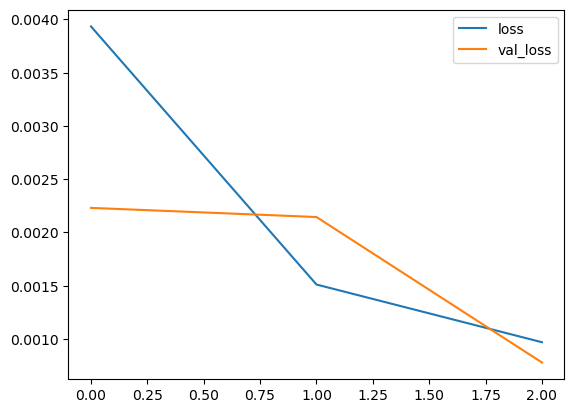

In [40]:
import matplotlib.pyplot as plt

plt.plot(hist_modelo.history["loss"], label='loss')
plt.plot(hist_modelo.history["val_loss"], label='val_loss')
plt.legend()

# Realização da predição dos dados de teste

In [41]:
resultado_z = modelo.predict(input_teste)



resultado_z.shape
input_teste.shape
dados_teste_z.shape
resultado_z

3/3 [==============================] - 1s 13ms/step


(87, 1)

(87, 15, 1)

(102, 1)

array([[0.8522146 ],
       [0.87107307],
       [0.8802123 ],
       [0.89263093],
       [0.9054564 ],
       [0.8904346 ],
       [0.86211526],
       [0.8434621 ],
       [0.82456553],
       [0.8198137 ],
       [0.80104613],
       [0.7754868 ],
       [0.7779007 ],
       [0.7978436 ],
       [0.8107178 ],
       [0.8210401 ],
       [0.81937414],
       [0.7998686 ],
       [0.76632214],
       [0.7608988 ],
       [0.78398454],
       [0.81788003],
       [0.84404206],
       [0.8622003 ],
       [0.87095344],
       [0.8707351 ],
       [0.86853576],
       [0.8726254 ],
       [0.8902245 ],
       [0.9210068 ],
       [0.9267837 ],
       [0.92212313],
       [0.9255789 ],
       [0.9382077 ],
       [0.94376564],
       [0.95307463],
       [0.952014  ],
       [0.94293946],
       [0.9145727 ],
       [0.896647  ],
       [0.86979985],
       [0.8412676 ],
       [0.86803347],
       [0.9029703 ],
       [0.92160654],
       [0.928919  ],
       [0.9054762 ],
       [0.887

# Análise dos resultados

In [42]:
resultado = scaler.inverse_transform(resultado_z)
real = scaler.inverse_transform(dados_teste_z)
real = dados_teste[dias_input-1:]


resultado.shape
real.shape
dados_teste.shape
dados_teste_z.shape

(87, 1)

(88,)

(102,)

(102, 1)

<Figure size 1800x900 with 0 Axes>

([<matplotlib.axis.XTick at 0x270bb86f160>,
 [Text(0, 0, '2021-08-25 00:00:00'),
  Text(5, 0, '2021-09-01 00:00:00'),
  Text(10, 0, '2021-09-09 00:00:00'),
  Text(15, 0, '2021-09-16 00:00:00'),
  Text(20, 0, '2021-09-23 00:00:00'),
  Text(25, 0, '2021-09-30 00:00:00'),
  Text(30, 0, '2021-10-07 00:00:00'),
  Text(35, 0, '2021-10-15 00:00:00'),
  Text(40, 0, '2021-10-22 00:00:00'),
  Text(45, 0, '2021-10-29 00:00:00'),
  Text(50, 0, '2021-11-08 00:00:00'),
  Text(55, 0, '2021-11-16 00:00:00'),
  Text(60, 0, '2021-11-23 00:00:00'),
  Text(65, 0, '2021-11-30 00:00:00'),
  Text(70, 0, '2021-12-07 00:00:00'),
  Text(75, 0, '2021-12-14 00:00:00'),
  Text(80, 0, '2021-12-21 00:00:00'),
  Text(85, 0, '2021-12-29 00:00:00')])

Text(0.5, 0, 'Datas')

Text(0, 0.5, 'Preço Final')

Text(0.5, 1.0, 'Projeção de Preço Petrobras')

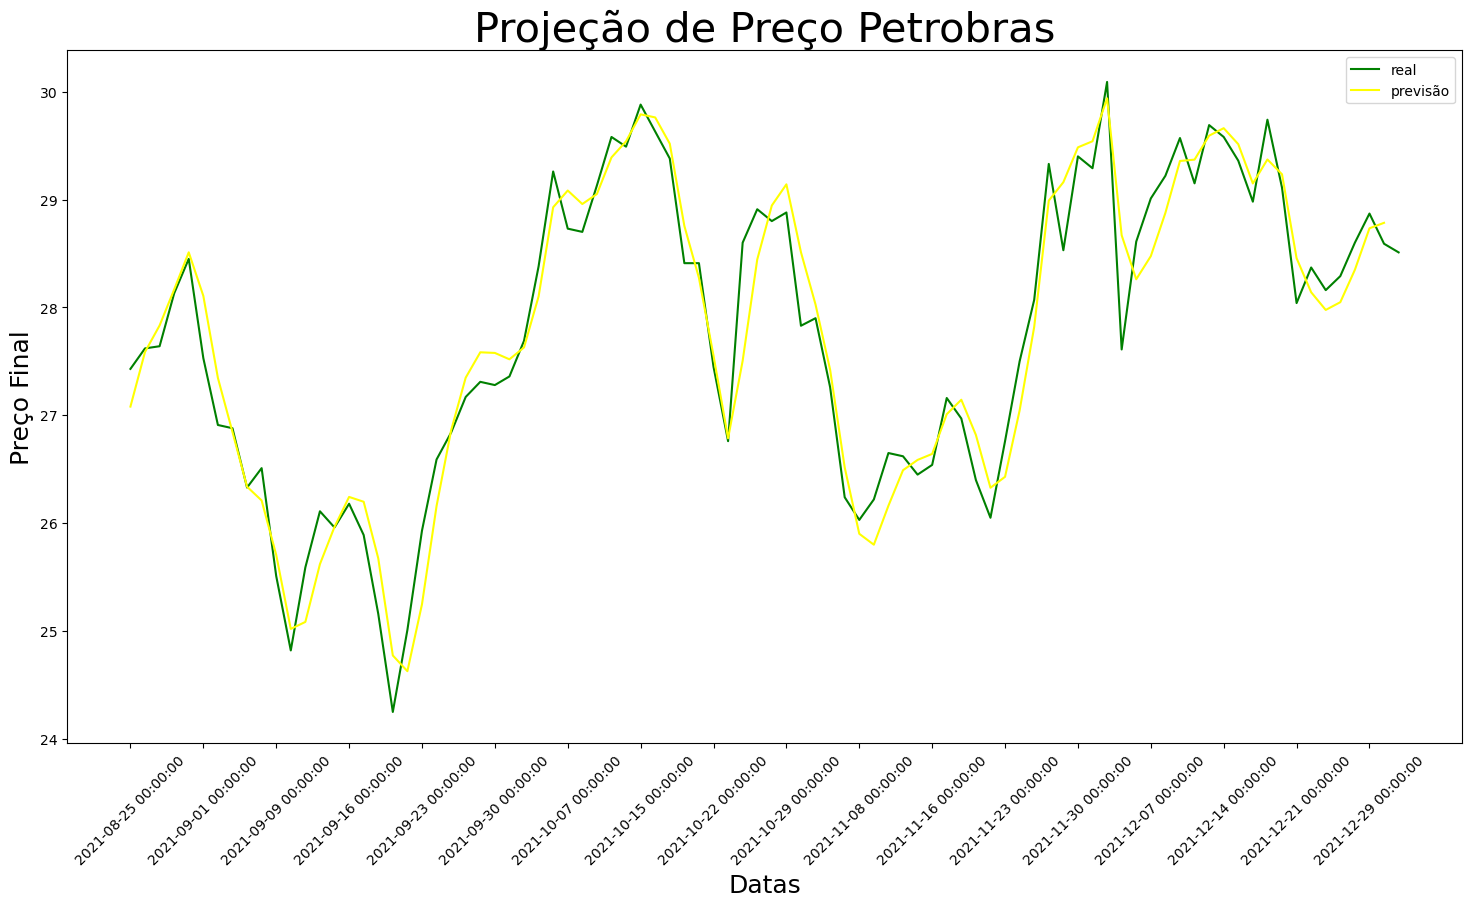

In [43]:



plt.figure(figsize = (18,9))
#plt.plot(dados_teste[:len(dados_teste)-dias_input], color = 'green', label = 'real')
plt.plot(real, color = 'green', label = 'real')
plt.plot(resultado, color = 'yellow', label = 'previsão')
#plt.xticks(range(0, len(dados_teste), 50), df_pet['Date'].iloc[- len(real)::50], rotation=45)
plt.xticks(range(0,len(input_teste),5), df_pet['DTPREG'].iloc[-len(input_teste)::5], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Final', fontsize=18)
plt.title("Projeção de Preço Petrobras", fontsize=30)
plt.legend()
plt.show()

# gerando as informações para predição das acões do Bradesco

In [44]:
df_bra['PREULT']=df_bra['PREULT']/100000

In [45]:
valores = df_bra['PREULT']
df_bra['PREULT']
valores

0       34.65
1       34.14
2       34.85
3       36.80
4       36.96
        ...  
1725    19.28
1726    19.40
1727    19.43
1728    19.30
1729    19.17
Name: PREULT, Length: 1730, dtype: float64

0       34.65
1       34.14
2       34.85
3       36.80
4       36.96
        ...  
1725    19.28
1726    19.40
1727    19.43
1728    19.30
1729    19.17
Name: PREULT, Length: 1730, dtype: float64

In [46]:
valores = df_bra['PREULT']


dados_teste = np.array(valores)
dados_teste_z = scaler.transform(np.array(dados_teste).reshape(-1,1))

#teste
input_teste = []
for i in range(dias_input,len(dados_teste_z)):
    input_teste.append(dados_teste_z[i-dias_input:i]) 
input_teste = np.array(input_teste)

resultado_z = modelo.predict(input_teste)

resultado = scaler.inverse_transform(resultado_z)
real = scaler.inverse_transform(dados_teste_z)

real = dados_teste[dias_input-1:]
real
resultado




54/54 [==============================] - 1s 11ms/step


array([35.86, 35.29, 35.62, ..., 19.43, 19.3 , 19.17])

array([[35.39953 ],
       [35.419617],
       [35.510124],
       ...,
       [19.259203],
       [19.384766],
       [19.409073]], dtype=float32)

<Figure size 1800x900 with 0 Axes>

([<matplotlib.axis.XTick at 0x270bb8d7820>,
 [Text(0, 0, '2015-01-23 00:00:00'),
  Text(60, 0, '2015-04-23 00:00:00'),
  Text(120, 0, '2015-07-21 00:00:00'),
  Text(180, 0, '2015-10-15 00:00:00'),
  Text(240, 0, '2016-01-15 00:00:00'),
  Text(300, 0, '2016-04-14 00:00:00'),
  Text(360, 0, '2016-07-11 00:00:00'),
  Text(420, 0, '2016-10-04 00:00:00'),
  Text(480, 0, '2017-01-02 00:00:00'),
  Text(540, 0, '2017-03-30 00:00:00'),
  Text(600, 0, '2017-06-28 00:00:00'),
  Text(660, 0, '2017-09-21 00:00:00'),
  Text(720, 0, '2017-12-20 00:00:00'),
  Text(780, 0, '2018-03-22 00:00:00'),
  Text(840, 0, '2018-06-19 00:00:00'),
  Text(900, 0, '2018-09-13 00:00:00'),
  Text(960, 0, '2018-12-12 00:00:00'),
  Text(1020, 0, '2019-03-15 00:00:00'),
  Text(1080, 0, '2019-06-11 00:00:00'),
  Text(1140, 0, '2019-09-05 00:00:00'),
  Text(1200, 0, '2019-12-02 00:00:00'),
  Text(1260, 0, '2020-03-03 00:00:00'),
  Text(1320, 0, '2020-05-29 00:00:00'),
  Text(1380, 0, '2020-08-24 00:00:00'),
  Text(1440, 0, 

Text(0.5, 0, 'Datas')

Text(0, 0.5, 'Preço Final')

Text(0.5, 1.0, 'Projeção de Preço BRADESCO')

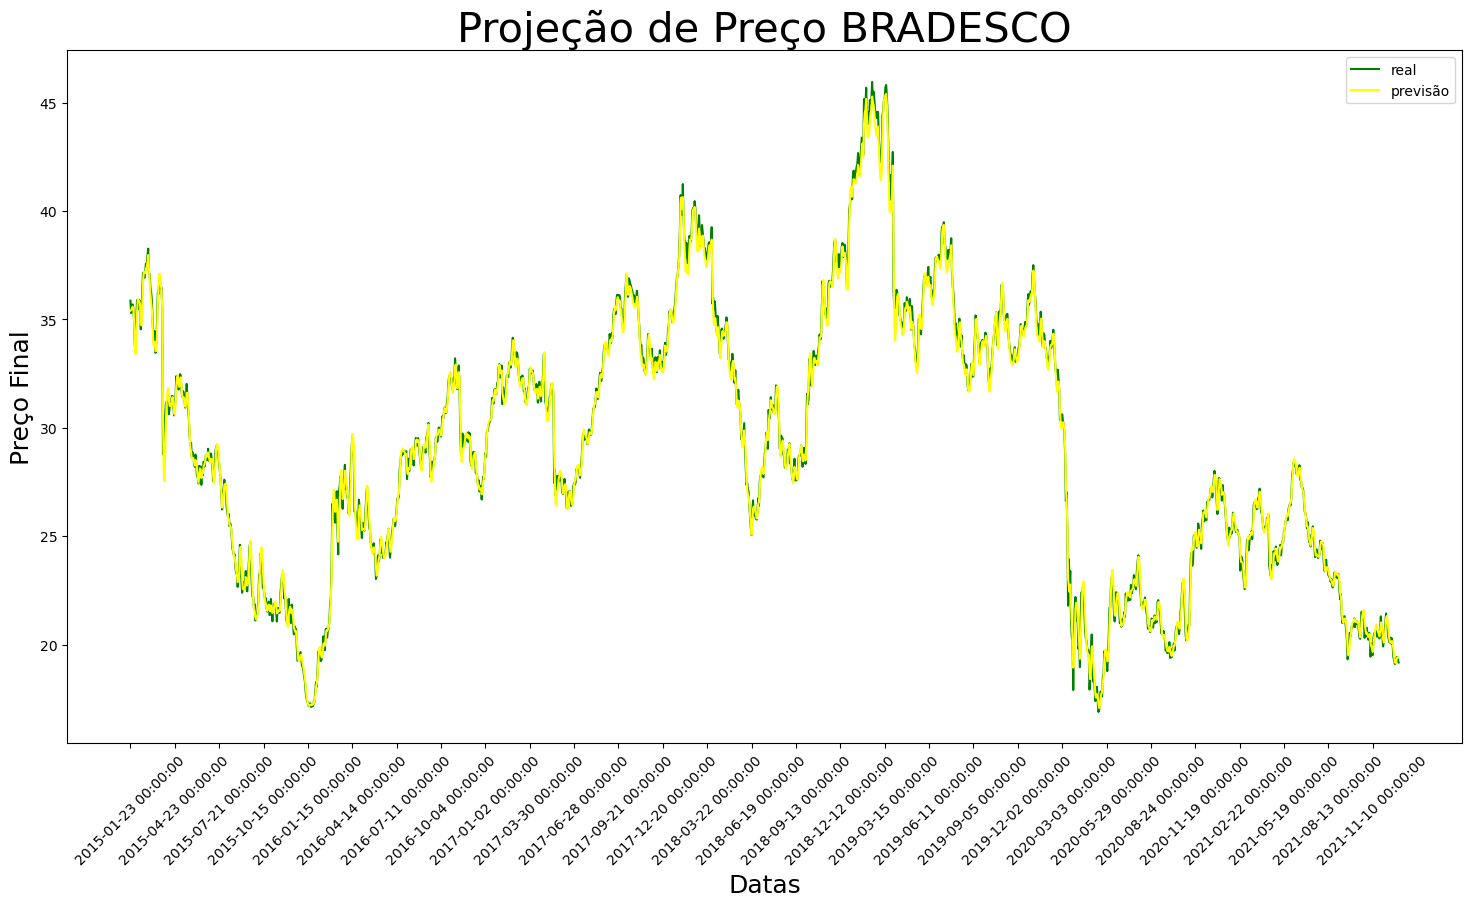

In [47]:
plt.figure(figsize = (18,9))
#plt.plot(dados_teste[:len(dados_teste)-dias_input], color = 'green', label = 'real')
plt.plot(real, color = 'green', label = 'real')
plt.plot(resultado, color = 'yellow', label = 'previsão')
#plt.xticks(range(0, len(dados_teste), 50), df_pet['Date'].iloc[- len(real)::50], rotation=45)
plt.xticks(range(0,len(input_teste),60), df_bra['DTPREG'].iloc[-len(input_teste)::60], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Final', fontsize=18)
plt.title("Projeção de Preço BRADESCO", fontsize=30)
plt.legend()
plt.show()

# Gerando as informações para a Vivo

In [48]:
df_viv['PREULT']=df_viv['PREULT']/100000
df_viv

,Unnamed: 0,index,TIPREG,DTPREG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,...,ANOPREG,Data,ibovespa,dolar_venda_media,dolar_venda_final,cdi,ipca,igpm,ipca_15,pib_milhoes
0,0,1377,1,2015-01-02,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,2015,2015.01,-6.2,2.634229,2.6623,0.93,1.24,0.76,0.89,472913.9
1,1,2929,1,2015-01-05,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,2015,2015.01,-6.2,2.634229,2.6623,0.93,1.24,0.76,0.89,472913.9
2,2,4565,1,2015-01-06,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,2015,2015.01,-6.2,2.634229,2.6623,0.93,1.24,0.76,0.89,472913.9
3,3,6254,1,2015-01-07,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,2015,2015.01,-6.2,2.634229,2.6623,0.93,1.24,0.76,0.89,472913.9
4,4,7866,1,2015-01-08,2,VIVT4,10,TELEF BRASIL,PN EJ,NaN,...,2015,2015.01,-6.2,2.634229,2.6623,0.93,1.24,0.76,0.89,472913.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,1452,256080,1,2020-11-16,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,2020,2020.11,15.9,5.417835,5.3317,0.15,0.89,3.28,0.81,665182.8
1453,1453,256081,1,2020-11-17,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,2020,2020.11,15.9,5.417835,5.3317,0.15,0.89,3.28,0.81,665182.8
1454,1454,256082,1,2020-11-18,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,2020,2020.11,15.9,5.417835,5.3317,0.15,0.89,3.28,0.81,665182.8
1455,1455,265642,1,2020-11-19,2,VIVT4,10,TELEF BRASIL,PN,NaN,...,2020,2020.11,15.9,5.417835,5.3317,0.15,0.89,3.28,0.81,665182.8


In [49]:
valores = df_viv['PREULT']


dados_teste = np.array(valores)
dados_teste_z = scaler.transform(np.array(dados_teste).reshape(-1,1))

#teste
input_teste = []
for i in range(dias_input,len(dados_teste_z)):
    input_teste.append(dados_teste_z[i-dias_input:i]) 
input_teste = np.array(input_teste)

resultado_z = modelo.predict(input_teste)

resultado = scaler.inverse_transform(resultado_z)
real = scaler.inverse_transform(dados_teste_z)

real = dados_teste[dias_input-1:]
real
resultado

46/46 [==============================] - 1s 11ms/step


array([51.96, 51.68, 50.82, ..., 46.94, 46.76, 45.65])

array([[51.544106],
       [51.136673],
       [50.01158 ],
       ...,
       [45.48282 ],
       [46.39718 ],
       [46.52076 ]], dtype=float32)

<Figure size 1800x900 with 0 Axes>

([<matplotlib.axis.XTick at 0x270bb98bf40>,
 [Text(0, 0, '2015-01-23 00:00:00'),
  Text(60, 0, '2015-04-23 00:00:00'),
  Text(120, 0, '2015-07-21 00:00:00'),
  Text(180, 0, '2015-10-15 00:00:00'),
  Text(240, 0, '2016-01-15 00:00:00'),
  Text(300, 0, '2016-04-14 00:00:00'),
  Text(360, 0, '2016-07-11 00:00:00'),
  Text(420, 0, '2016-10-04 00:00:00'),
  Text(480, 0, '2017-01-02 00:00:00'),
  Text(540, 0, '2017-03-30 00:00:00'),
  Text(600, 0, '2017-06-28 00:00:00'),
  Text(660, 0, '2017-09-21 00:00:00'),
  Text(720, 0, '2017-12-20 00:00:00'),
  Text(780, 0, '2018-03-22 00:00:00'),
  Text(840, 0, '2018-06-19 00:00:00'),
  Text(900, 0, '2018-09-13 00:00:00'),
  Text(960, 0, '2018-12-12 00:00:00'),
  Text(1020, 0, '2019-03-15 00:00:00'),
  Text(1080, 0, '2019-06-11 00:00:00'),
  Text(1140, 0, '2019-09-05 00:00:00'),
  Text(1200, 0, '2019-12-02 00:00:00'),
  Text(1260, 0, '2020-03-03 00:00:00'),
  Text(1320, 0, '2020-05-29 00:00:00'),
  Text(1380, 0, '2020-08-24 00:00:00'),
  Text(1440, 0, 

Text(0.5, 0, 'Datas')

Text(0, 0.5, 'Preço Final')

Text(0.5, 1.0, 'Projeção de Preço Vivo')

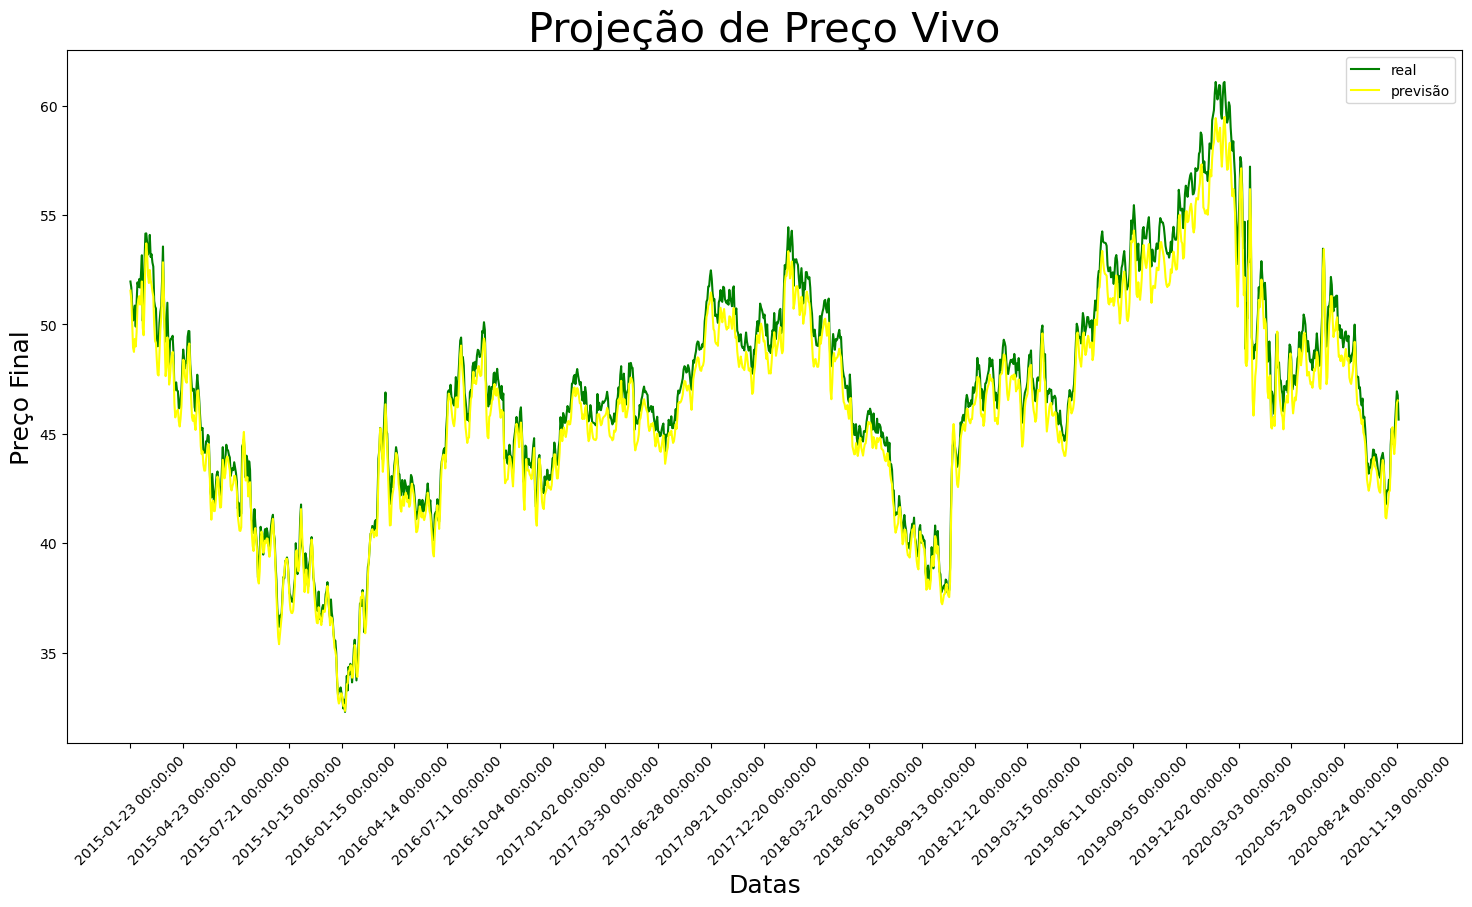

In [50]:
plt.figure(figsize = (18,9))
#plt.plot(dados_teste[:len(dados_teste)-dias_input], color = 'green', label = 'real')
plt.plot(real, color = 'green', label = 'real')
plt.plot(resultado, color = 'yellow', label = 'previsão')
#plt.xticks(range(0, len(dados_teste), 50), df_pet['Date'].iloc[- len(real)::50], rotation=45)
plt.xticks(range(0,len(input_teste),60), df_viv['DTPREG'].iloc[-len(input_teste)::60], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Final', fontsize=18)
plt.title("Projeção de Preço Vivo", fontsize=30)
plt.legend()
plt.show()

# realizando a predição dia a dia para atualizar os inputs

In [51]:
input_pred = input_teste[0:1].copy() #pega o primeiro dia do conjunto de teste
predicoes = []
for i in range(len(dados_teste)):
    
    resultado = modelo.predict(input_pred)
    predicoes.append(resultado[0, 0])
    
    #remove primeiro preço da sequência
    temp = np.delete(input_pred[0], 0)

    #insere último preço da sequência
    temp = np.append(temp, resultado)
    
    #recoloca no formato tensorflow
    input_pred[0] = np.reshape(temp, (dias_input, 1))
    
predicoes = scaler.inverse_transform(np.array(predicoes).reshape(-1, 1))

predicoes

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 38ms/step


array([[51.544094],
       [51.026268],
       [50.125313],
       ...,
       [27.753283],
       [27.753283],
       [27.753283]], dtype=float32)

In [ ]:
len(dados_teste)

plt.figure(figsize = (18,9))
plt.plot(dados_teste, color = 'green', label = 'real')
plt.plot(predicoes, color = 'red', label = 'previsão')
plt.xticks(range(0, len(dados_teste), 10), df_pet['DTPREG'].iloc[-len(dados_teste)::10], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Final', fontsize=18)
plt.title("Projeção de Preço", fontsize=30)
plt.legend()
plt.show()